# Binary Systems in Astrophysics WS 2021/2022

For this tutorial we will learn how to search for a period in some very-high energy (VHE) data using a different method than last week. We will use gamma-ray data from the High Energy Stereoscopic System (H.E.S.S. , https://www.mpi-hd.mpg.de/hfm/HESS/), the Major Atmospheric Gamma-ray Imaging Cherenkov (MAGIC, https://magic.mpp.mpg.de/), and the Very Energetic Radiation Imaging Telescope Array System (VERITAS, https://veritas.sao.arizona.edu/). 

In particular, we will reproduce some results from the original publication  "Observation of the gamma-ray binary HESS J0632+057 with the H.E.S.S., MAGIC, and VERITAStelescopes" (https://arxiv.org/pdf/2109.11894.pdf).

As always, you can get this jupyter notebook entering your local binary folder linked to GitLab and pulling the new material:

$ git pull

For today you will also need the package PyAstronomy (https://github.com/sczesla/PyAstronomy). To get it, write on the terminal:

$ pip install PyAstronomy[occult]

 ## 4. Phase dispersion minimisation (PDM)


Last week we discussed the possibility of searching for periods using the Lomb-Scargle algorithm, which is a method based on a Fourier transformation. There, we move from the time domain, to the Fourier space of frequencies:

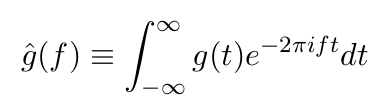

where a sinusoidal signal can be reconstructed as a Dirac delta

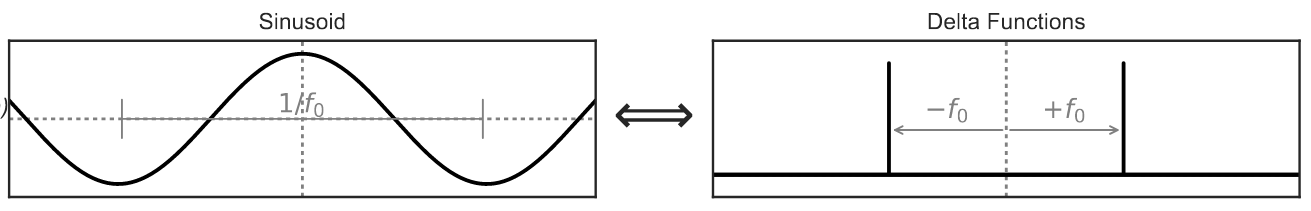

Remember that for more details on the Lomb-Scargle periodogram and Fourier transformations you can check VanderPlas 2018 here https://arxiv.org/pdf/1703.09824.pdf

However, period searches are not exclusively restricted to the usage of Fourier methods. Another common option is using phase-folding methods. Although they can be less powerfull, they generally do not rely on any assumption on the shape of the lightcurve, and provide an independent algorithm. The most famous of those is Phase Dispersion Minimisation (or PDM), developed by Stellingwerf in 1978 (http://articles.adsabs.harvard.edu/pdf/1978ApJ...224..953S). 

Consider that you have a distribution of $N$ observations $x$. The corresponding distribution's standard deviation will be

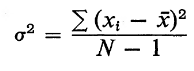

Now imagine you construct a binned light curve of n bins. The standard deviation in this case will be

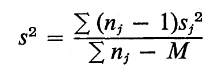

Although we do not know its shape, we know that the signal is periodical. Therefore we use a trial period $\Pi$, and bin our data in its corresponding phase-space, where observations will have assigned a phase $\phi$ according to

We can finally construct as $\theta$ statistic as

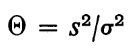

If $\Pi$ is not the true period, $s \sim \sigma$, and thus $\theta \sim 1$. But if $\Pi$ is the real period, the dispersion of $s$ will be way smaller, since all bins will should contain similar flux levels. 

Therefore minimizing $\theta$ we will find the period of the object we are studying :D

$\;$

But how do we use it? Let's create some noisy data (like in https://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html#astropy.timeseries.LombScargle)

In [1]:
import numpy as np
rand = np.random.default_rng(42)
t = 100 * rand.random(100)
y = np.sin(2 * np.pi * t)  + rand.standard_normal(100)/10 ## Period of 1 in arbitrary units

If we represent the data we can see how it is quite scattered and it is not obvious that we have a period hidden.

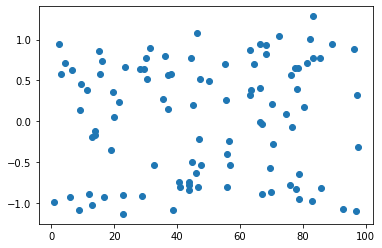

In [2]:
import matplotlib.pyplot as plt
plt.plot(t,y,'o')

So how can we recover the period using PDM? We can use the pyAstronomy implementation. With just a few lines, we can perform the analysis (example from https://pyastronomy.readthedocs.io/en/latest/pyTimingDoc/pyPDMDoc/examples.html#carry-out-a-pdm-analysis)

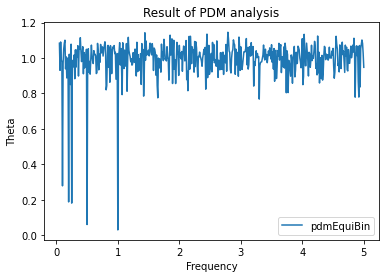

In [3]:
import numpy
import matplotlib.pylab as plt
from PyAstronomy.pyTiming import pyPDM

# A scanner defines the frequency interval to be checked.
# Alternatively, also periods could be used instead of frequency.
S = pyPDM.Scanner(minVal=0.05, maxVal=5.0, dVal=0.01, mode="frequency")

# Carry out PDM analysis. Get frequency array
# (f, note that it is frequency, because the scanner's
# mode is frequency) and associated Theta statistic (t).
P = pyPDM.PyPDM(t, y)
#PDM analysis using 10 bins equidistant bins
f, theta = P.pdmEquiBin(20, S)


# Show the result
plt.figure(facecolor='white')
plt.title("Result of PDM analysis")
plt.xlabel("Frequency")
plt.ylabel("Theta")
plt.plot(f, theta, '-')
plt.legend(["pdmEquiBin"])
plt.show()

It works? $\textit{fantastique}$! We can obtain the original period, and also the harmonics :)

Other things that might be useful:
- The scanner can be defined in a period grid
- You can define "covers": this is, phase-shifted set of bins to compare if your result is spurious or not.
- We can plot the phase-folded light curve

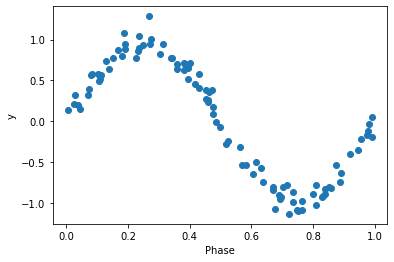

In [6]:
phase, ind = P.phase(time=t,period=1)
plt.xlabel("Phase")
plt.ylabel("y")
plt.plot(phase[ind], y[ind],'o')

So we have reconstructed the period properly!

### Exercise

Use the PDM implementation in wherever to find the period of the binary HESS J0632+057 in the multi-instrument VHE data provided (from https://arxiv.org/pdf/2109.11894.pdf, also available at https://zenodo.org/record/5157848). Restrict yourself on periods between 300 and 365 days. Produce a phase-folded plot. Which main features do you observe?

Note: The time units are in MJD (Modified Julian Day)! Use as time the average between the maxmimum and minimum time of an observation. 

ACHTUNG! Given that the data is from 3 different instruments, it might not have exactly the same format.

In [22]:
from astropy.table import Table as tb
data_hess = tb.read('../data/LightCurve-HESS.ecsv', format='ascii.ecsv')
data_magic = tb.read('../data/LightCurve-MAGIC.ecsv', format='ascii.ecsv')
data_veritas = tb.read('../data/LightCurve-VERITAS.ecsv', format='ascii.ecsv')

Text(0, 0.5, 'Photon flux (ph /cm² /s)')

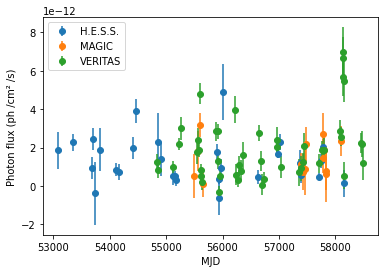

In [23]:
import matplotlib.pyplot as plt
import numpy as np
plt.errorbar(data_hess['time_min'], data_hess['flux'],yerr=(data_hess['flux_up']-data_hess['flux_down'])/2.0,fmt='o',label='H.E.S.S.')
plt.errorbar(data_magic['time_min'], data_magic['flux'],yerr=data_magic['flux_err'],fmt='o',label='MAGIC')
plt.errorbar(data_veritas['time_min'], data_veritas['flux'],yerr=data_veritas['flux_err'],fmt='o',label='VERITAS')
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Photon flux (ph /cm² /s)')

In [24]:
flux = data_hess['flux'].tolist()+data_magic['flux'].tolist()+data_veritas['flux'].tolist()
time = data_hess['time_min'].tolist()+data_magic['time_min'].tolist()+data_veritas['time_min'].tolist()

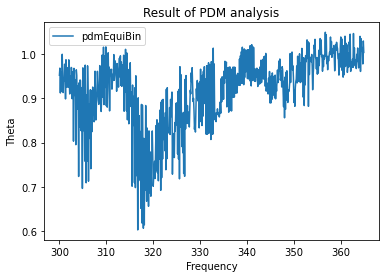

In [29]:
import numpy as np
S = pyPDM.Scanner(minVal=300, maxVal=365, dVal=0.1, mode="period")

# Carry out PDM analysis. Get frequency array
# (f, note that it is frequency, because the scanner's
# mode is frequency) and associated Theta statistic (t).
P = pyPDM.PyPDM(np.array(time), np.array(flux))
#PDM analysis using 10 bins equidistant bins
per, theta = P.pdmEquiBin(10, S)


# Show the result
plt.figure(facecolor='white')
plt.title("Result of PDM analysis")
plt.xlabel("Frequency")
plt.ylabel("Theta")
plt.plot(per, theta, '-')
plt.legend(["pdmEquiBin"])
plt.show()

In [28]:
len(flux)

90

In [30]:
min(theta)

0.6034544783321547

In [38]:

Period = per[(theta.tolist()).index(min(theta))]
print(Period)

316.7000000000038


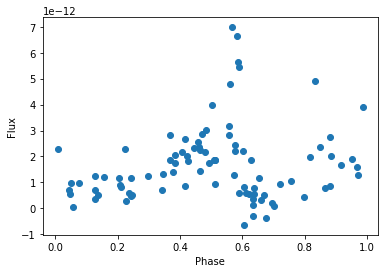

In [37]:
phase, ind = P.phase(time=time,period=Period)
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.plot(phase[ind], np.array(flux)[ind],'o')